In [1]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sns

from scroutines.config_plots import *
from scroutines import basicu
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
def get_eta2_allgenes(nums):
    """
    nums: c1,c2,...,n matrix - ... conditions by n genes
    
    return (eta2, stdv) - vectors one entry for each gene
    """
    nc0, nc1, nc2, ng = nums.shape # (num time points, num rep, num genes)

    nums_m  = np.mean(nums, axis=(0,1,2)) #
    nums_m0 = np.mean(nums, axis=(1,2))   # 0
    nums_m1 = np.mean(nums, axis=(0,2))   # 0
    nums_m2 = np.mean(nums, axis=(0,1))   # 0
    

    # # SSt 
    diff = nums - np.expand_dims(nums_m , axis=(0,1,2))
    SSt  = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    # # SSw
    diff = nums - np.expand_dims(nums_m0, axis=(1,2))
    SSw0 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m1, axis=(0,2))
    SSw1 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m2, axis=(0,1))
    SSw2 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    eta2_0 = (1-(SSw0+1e-6)/(SSt+1e-6))
    eta2_1 = (1-(SSw1+1e-6)/(SSt+1e-6))
    eta2_2 = (1-(SSw2+1e-6)/(SSt+1e-6))
    
    # stdb = np.sqrt((SSt-SSw)/(nt*nr))
    return eta2_0, eta2_1, eta2_2



# check features

In [3]:
f = "../../data/jain22_nature_flybrain/scEcRDN.h5ad"
# f = "../../data/jain22_nature_flybrain/scEcRRNAi.h5ad"
# f = "../../data/jain22_nature_flybrain/scHr3RNAi.h5ad"
adata = anndata.read(f)
adata

AnnData object with n_obs × n_vars = 5082 × 17562
    obs: 'replicate', 'genotype', 'time', 'condition', 'celltype', 'cell_condition', 'time_condition', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [4]:
adata = adata[adata.obs['condition']=='WT']
counts = adata.raw.X
counts

<3596x17562 sparse matrix of type '<class 'numpy.float64'>'
	with 6038323 stored elements in Compressed Sparse Row format>

In [5]:
nt, nc, nr = 4, 5, 2

mat = counts
_types = adata.obs['time']+'_'+adata.obs['celltype']+'_'+adata.obs['replicate']
_xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, _types) 

xclsts = _xclsts.reshape(nt, nc, nr)
pbulks = Xk_ln.reshape(nt, nc, nr, 17562)

pbulks.shape, xclsts.shape

((4, 5, 2, 17562), (4, 5, 2))

In [6]:
genes = adata.var.index.values
genes

array(['tdTom', 'Nep3', 'tRNA:Pro-CGG-1-1', ..., 'CG13949', 'CG13950',
       'ninaA'], dtype=object)

In [7]:
eta2_t, eta2_c, eta2_r = get_eta2_allgenes(pbulks)

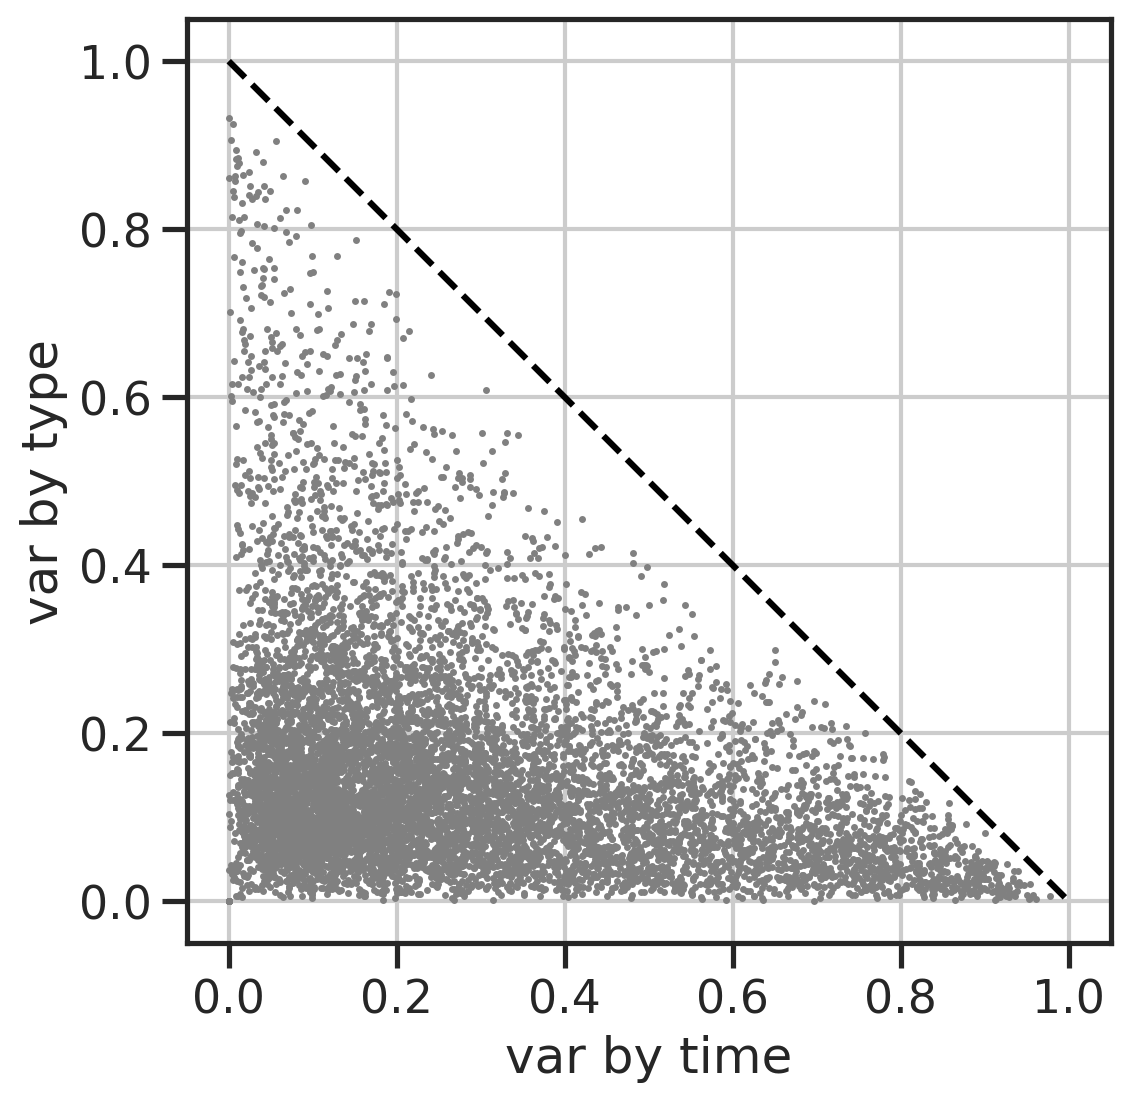

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()


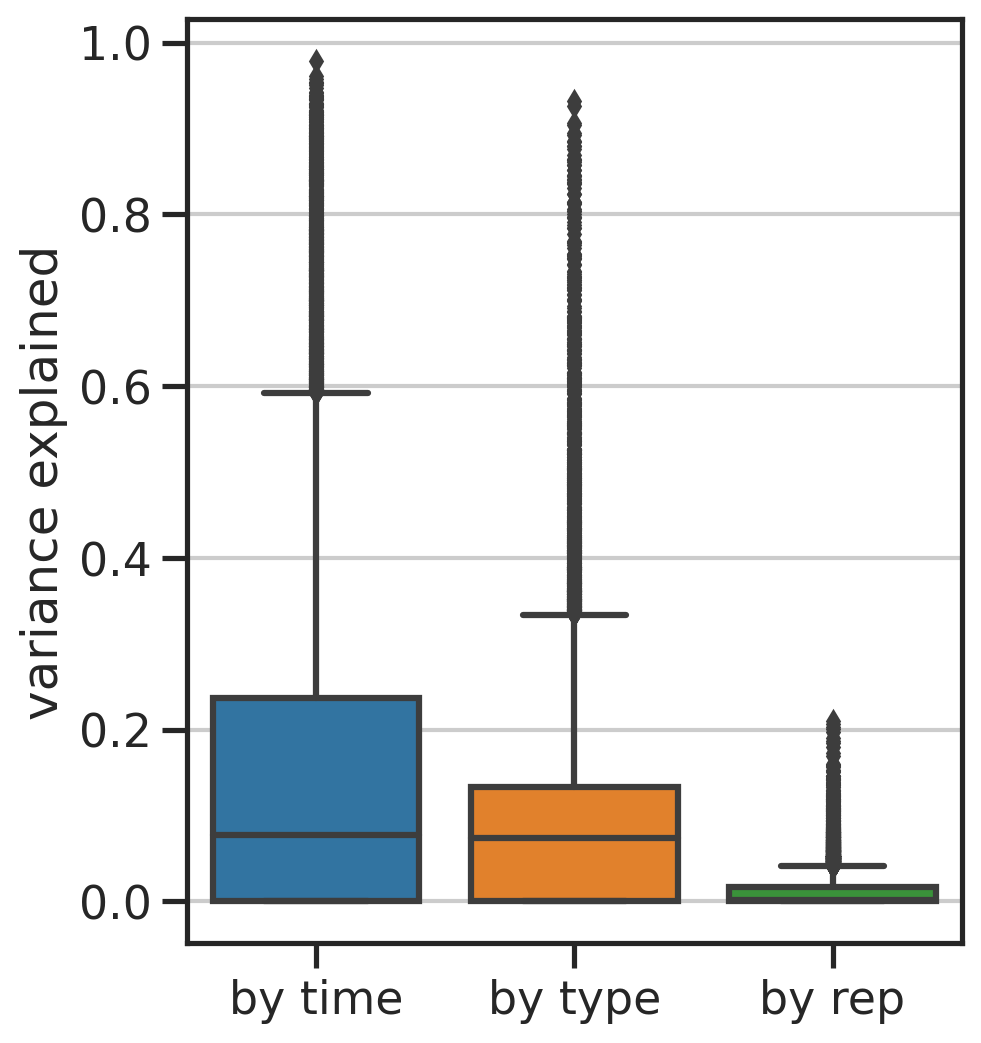

In [9]:
fig, ax = plt.subplots(figsize=(5,6))
sns.boxplot([eta2_t, eta2_c, eta2_r])
ax.set_xticklabels(['by time', 'by type', 'by rep'])
ax.set_ylabel('variance explained')
plt.show()

In [10]:
types = ['L1', 'L2', 'L3', 'L4', 'L5']
ts = [24,48,72,96]

colors = sns.color_palette('Set2', len(types))
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

In [11]:
gi = np.argmax(eta2_t)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(12996,
 'Kr-h1',
 0.9781844715495809,
 0.0063543311952194426,
 5.4528955330535034e-05,
 0.9845933317001309)

In [12]:
gi = np.argmax(eta2_c)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(11579,
 'bru3',
 0.0008222295848191452,
 0.9324041881735115,
 0.012602622586505907,
 0.9458290403448365)

In [13]:
pbulks_g = pbulks[:,:,:,gi]
pbulks_g = np.moveaxis(pbulks_g, 0, -1) # nt, nc, nr -> nc, nr, nt
gname = genes[gi]
print(pbulks_g.shape)

(5, 2, 4)


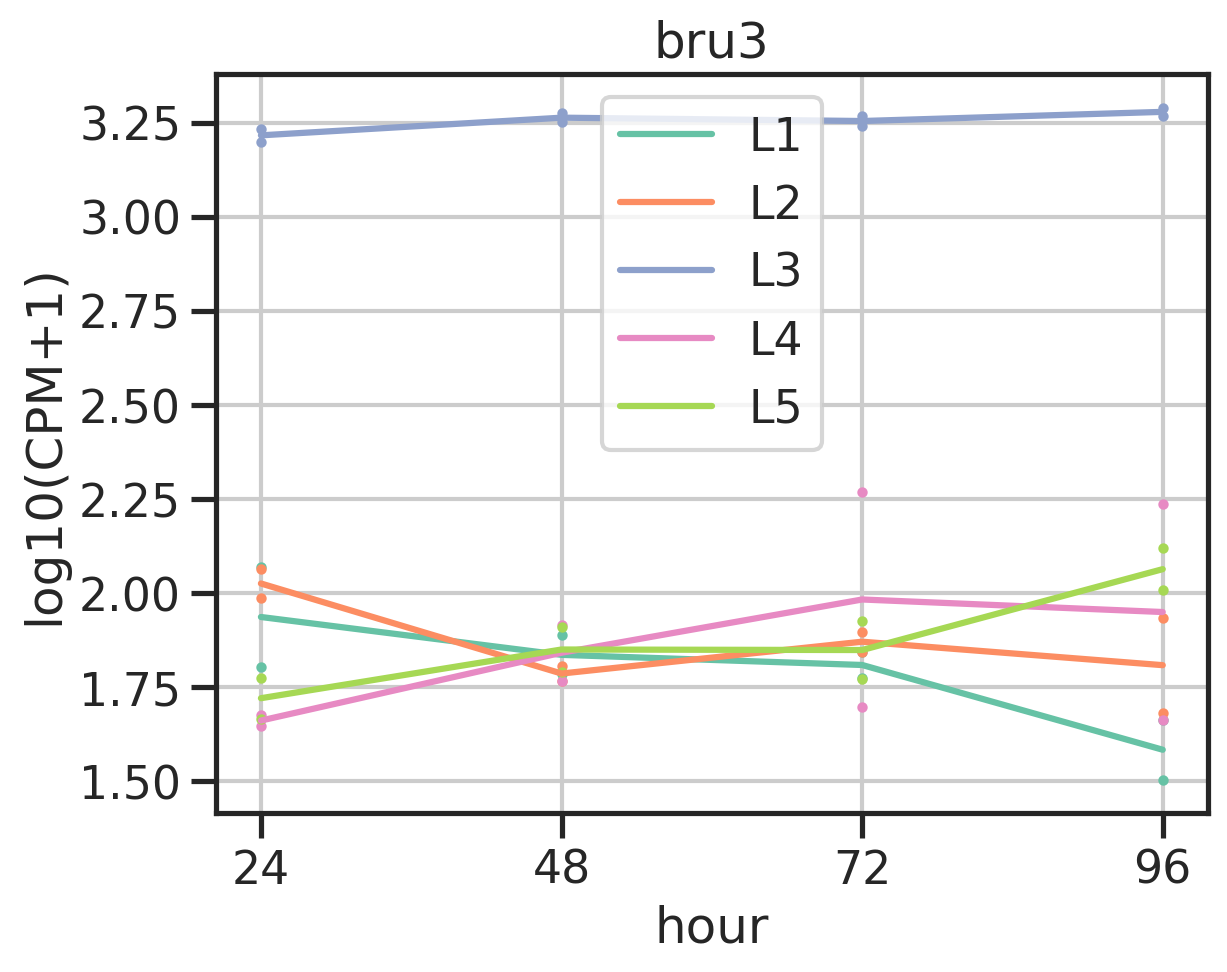

In [14]:
fig, ax = plt.subplots()
ax.set_title(gname)
for i in range(5):
    color = colors[i]
    lbl = types[i]
    ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
    ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
    ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
ax.set_xticks(ts)
ax.legend()
ax.set_ylabel('log10(CPM+1)')
ax.set_xlabel('hour')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


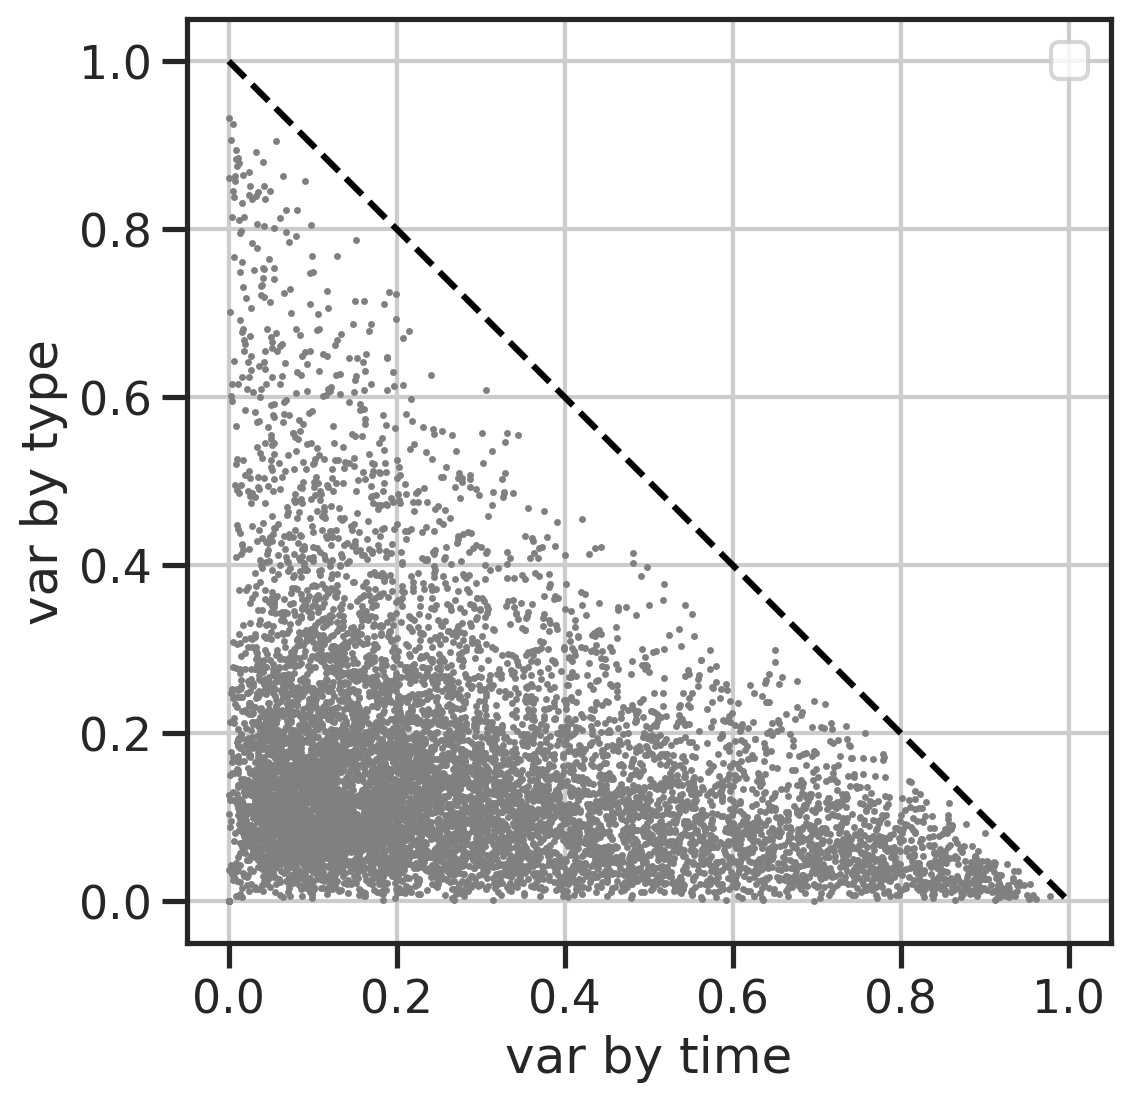

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
# ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
# ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
# ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [16]:
cond = (eta2_t + eta2_c > 0.8)

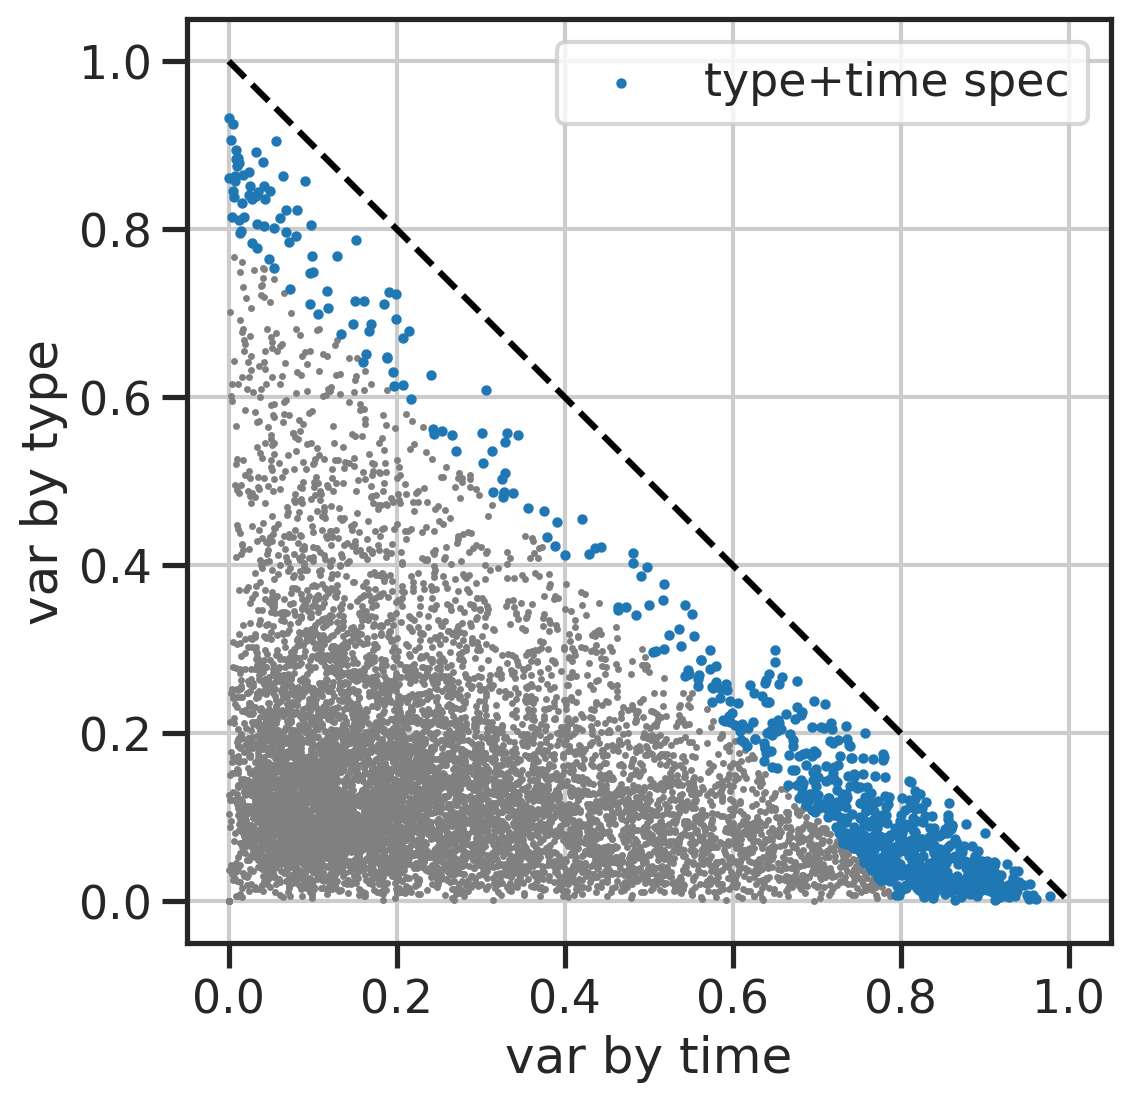

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(eta2_t[cond], eta2_c[cond], s=5, color='C0', label='type+time spec')
# ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
# ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
# ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [18]:
res = pd.DataFrame(index=genes)
res['eta2_t'] = eta2_t
res['eta2_c'] = eta2_c
res['eta2_tc'] = eta2_t+eta2_c
res['spec'] = eta2_t+eta2_c>0.8
res = res[res['spec']]

res

,eta2_t,eta2_c,eta2_tc,spec
RpL10,0.751871,0.099302,0.851173,True
CG5273,0.700512,0.111611,0.812122,True
RpL36,0.696073,0.154184,0.850257,True
CG13364,0.816363,0.063467,0.879830,True
CG13365,0.758675,0.108833,0.867508,True
...,...,...,...,...
Uch,0.793141,0.047753,0.840895,True
aop,0.575078,0.255209,0.830287,True
erm,0.005263,0.844955,0.850217,True
Eno,0.859361,0.086226,0.945587,True


In [19]:
bins = np.linspace(0, 1, 6)
lbls = [1,2,3,4,5]
res['cbin'] = pd.cut(res['eta2_c'], bins, labels=lbls)

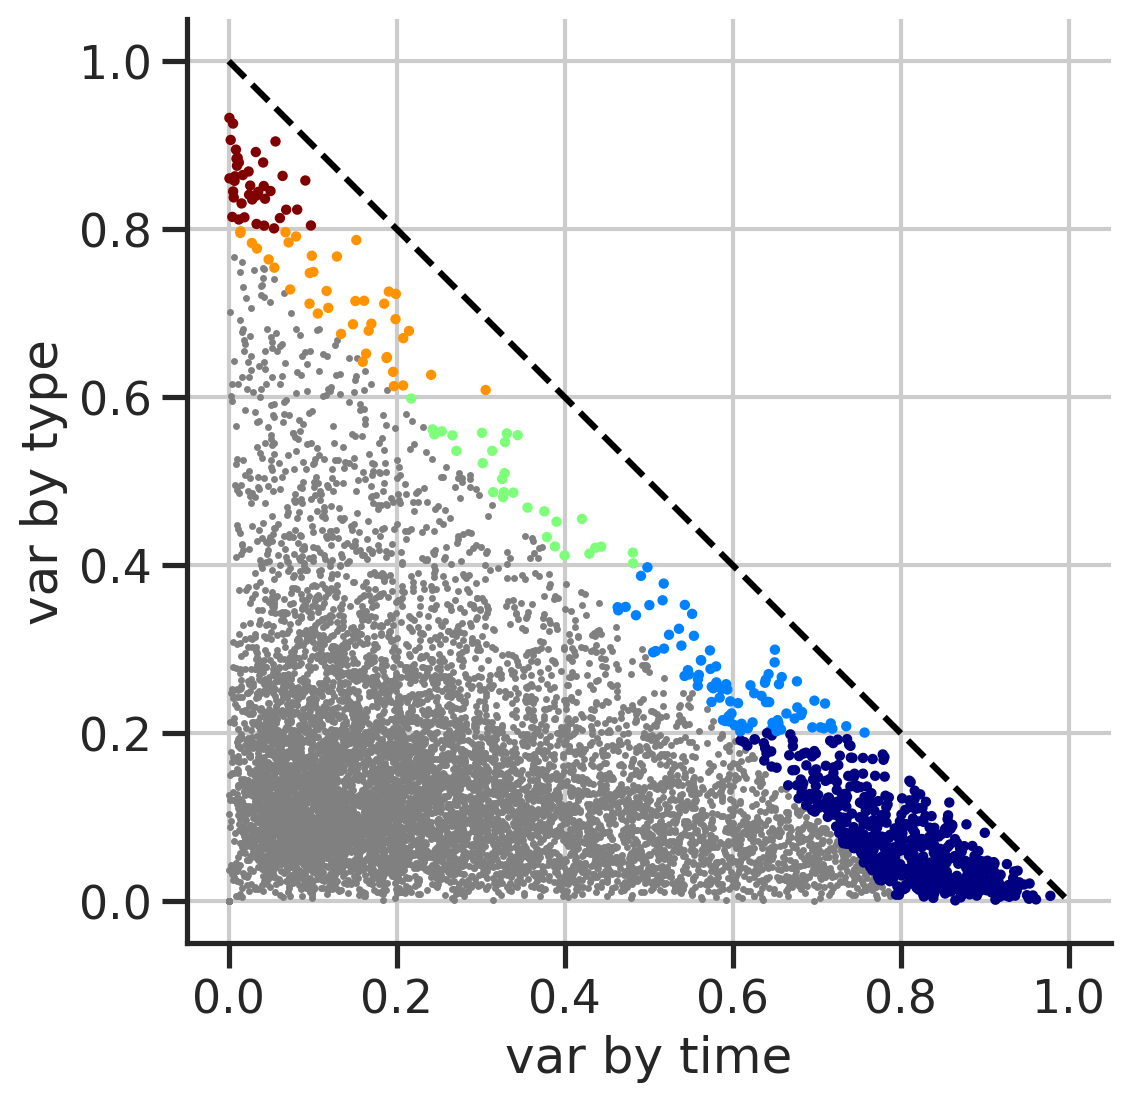

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(res['eta2_t'], res['eta2_c'], c=res['cbin'], s=5, cmap='jet')

ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
sns.despine(ax=ax)
# ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

# top 5 for each bin

In [21]:
newres = []
for _bin, res_sub in res.groupby('cbin'):
    print(_bin, res_sub.shape)
    newres.append(res_sub.sort_values('eta2_tc', ascending=False).head(5))
newres = pd.concat(newres[::-1])
newres

1 (600, 5)
2 (85, 5)
3 (31, 5)
4 (40, 5)
5 (39, 5)


,eta2_t,eta2_c,eta2_tc,spec,cbin
SoxN,0.055707,0.904446,0.960153,True,5
dac,0.091228,0.857923,0.949151,True,5
bru3,0.000822,0.932404,0.933226,True,5
CG11635,0.005169,0.925729,0.930898,True,5
CG42339,0.064171,0.863406,0.927577,True,5
Ten-a,0.151966,0.787057,0.939023,True,4
CG31997,0.198989,0.722940,0.921929,True,4
CG43901,0.190614,0.725689,0.916303,True,4
kune,0.305884,0.608497,0.914381,True,4
VAChT,0.185102,0.711277,0.896379,True,4


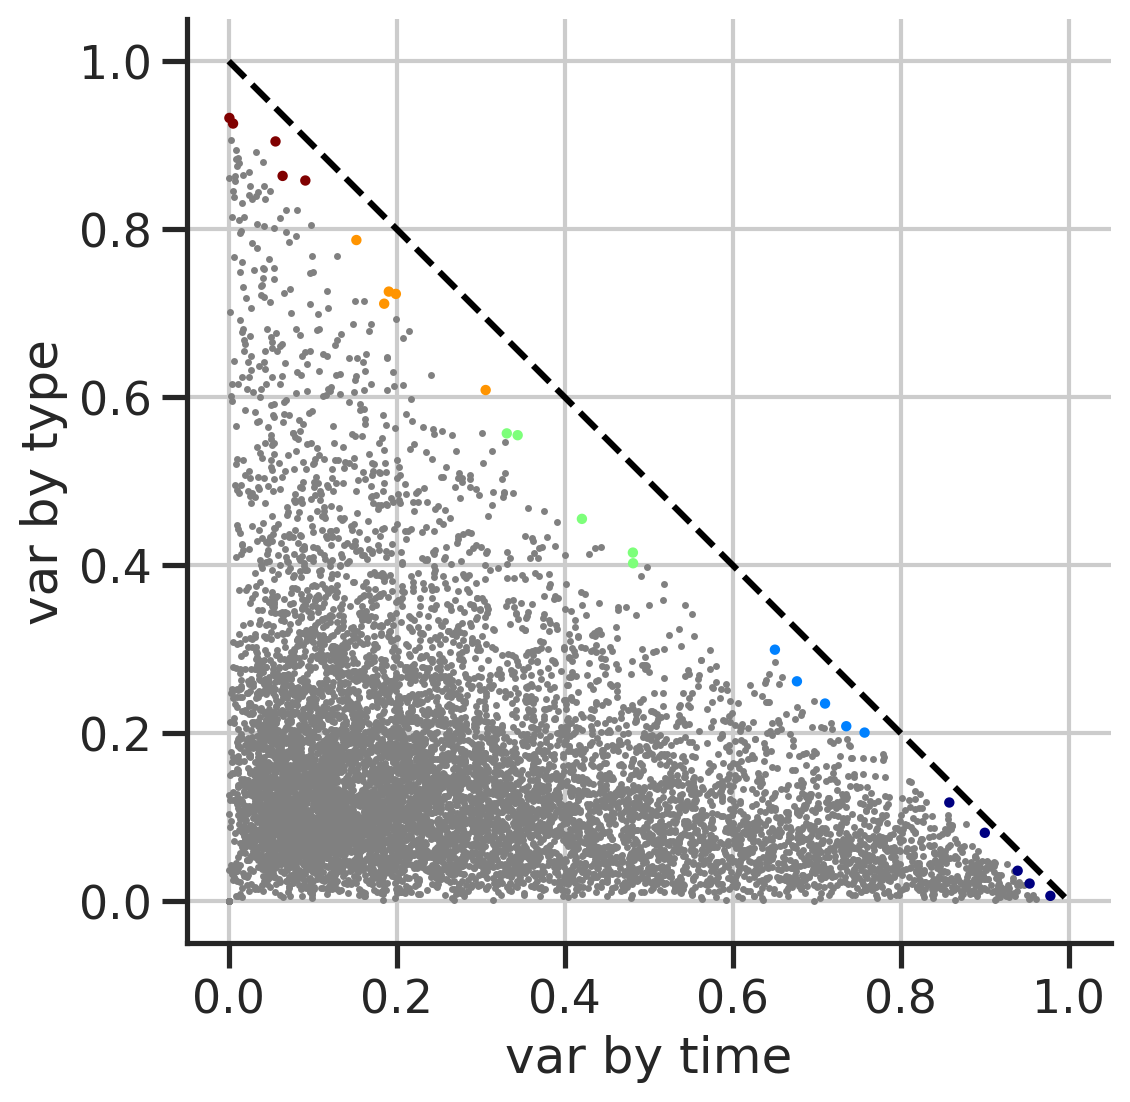

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(newres['eta2_t'], newres['eta2_c'], c=newres['cbin'], s=5, cmap='jet')

ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
sns.despine(ax=ax)
# ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [23]:
gi = basicu.get_index_from_array(genes, newres.index.values)
gi

array([ 1432,  7892, 11579,  6947,  9664, 13398,  7171, 11746,  5057,
       14259, 12978,  3103,  7828, 14400, 17109,  3192,   746, 10273,
       15962, 15711, 12996, 16255,  6365, 14982,  4817])

In [24]:
pbulks_sub = pbulks[:,:,:,gi]
pbulks_sub = np.swapaxes(pbulks_sub, 0, -1) # nt, nc, nr, ng -> ng, nc, nr, nt
gnames = genes[gi]
print(pbulks_g.shape)

(5, 2, 4)


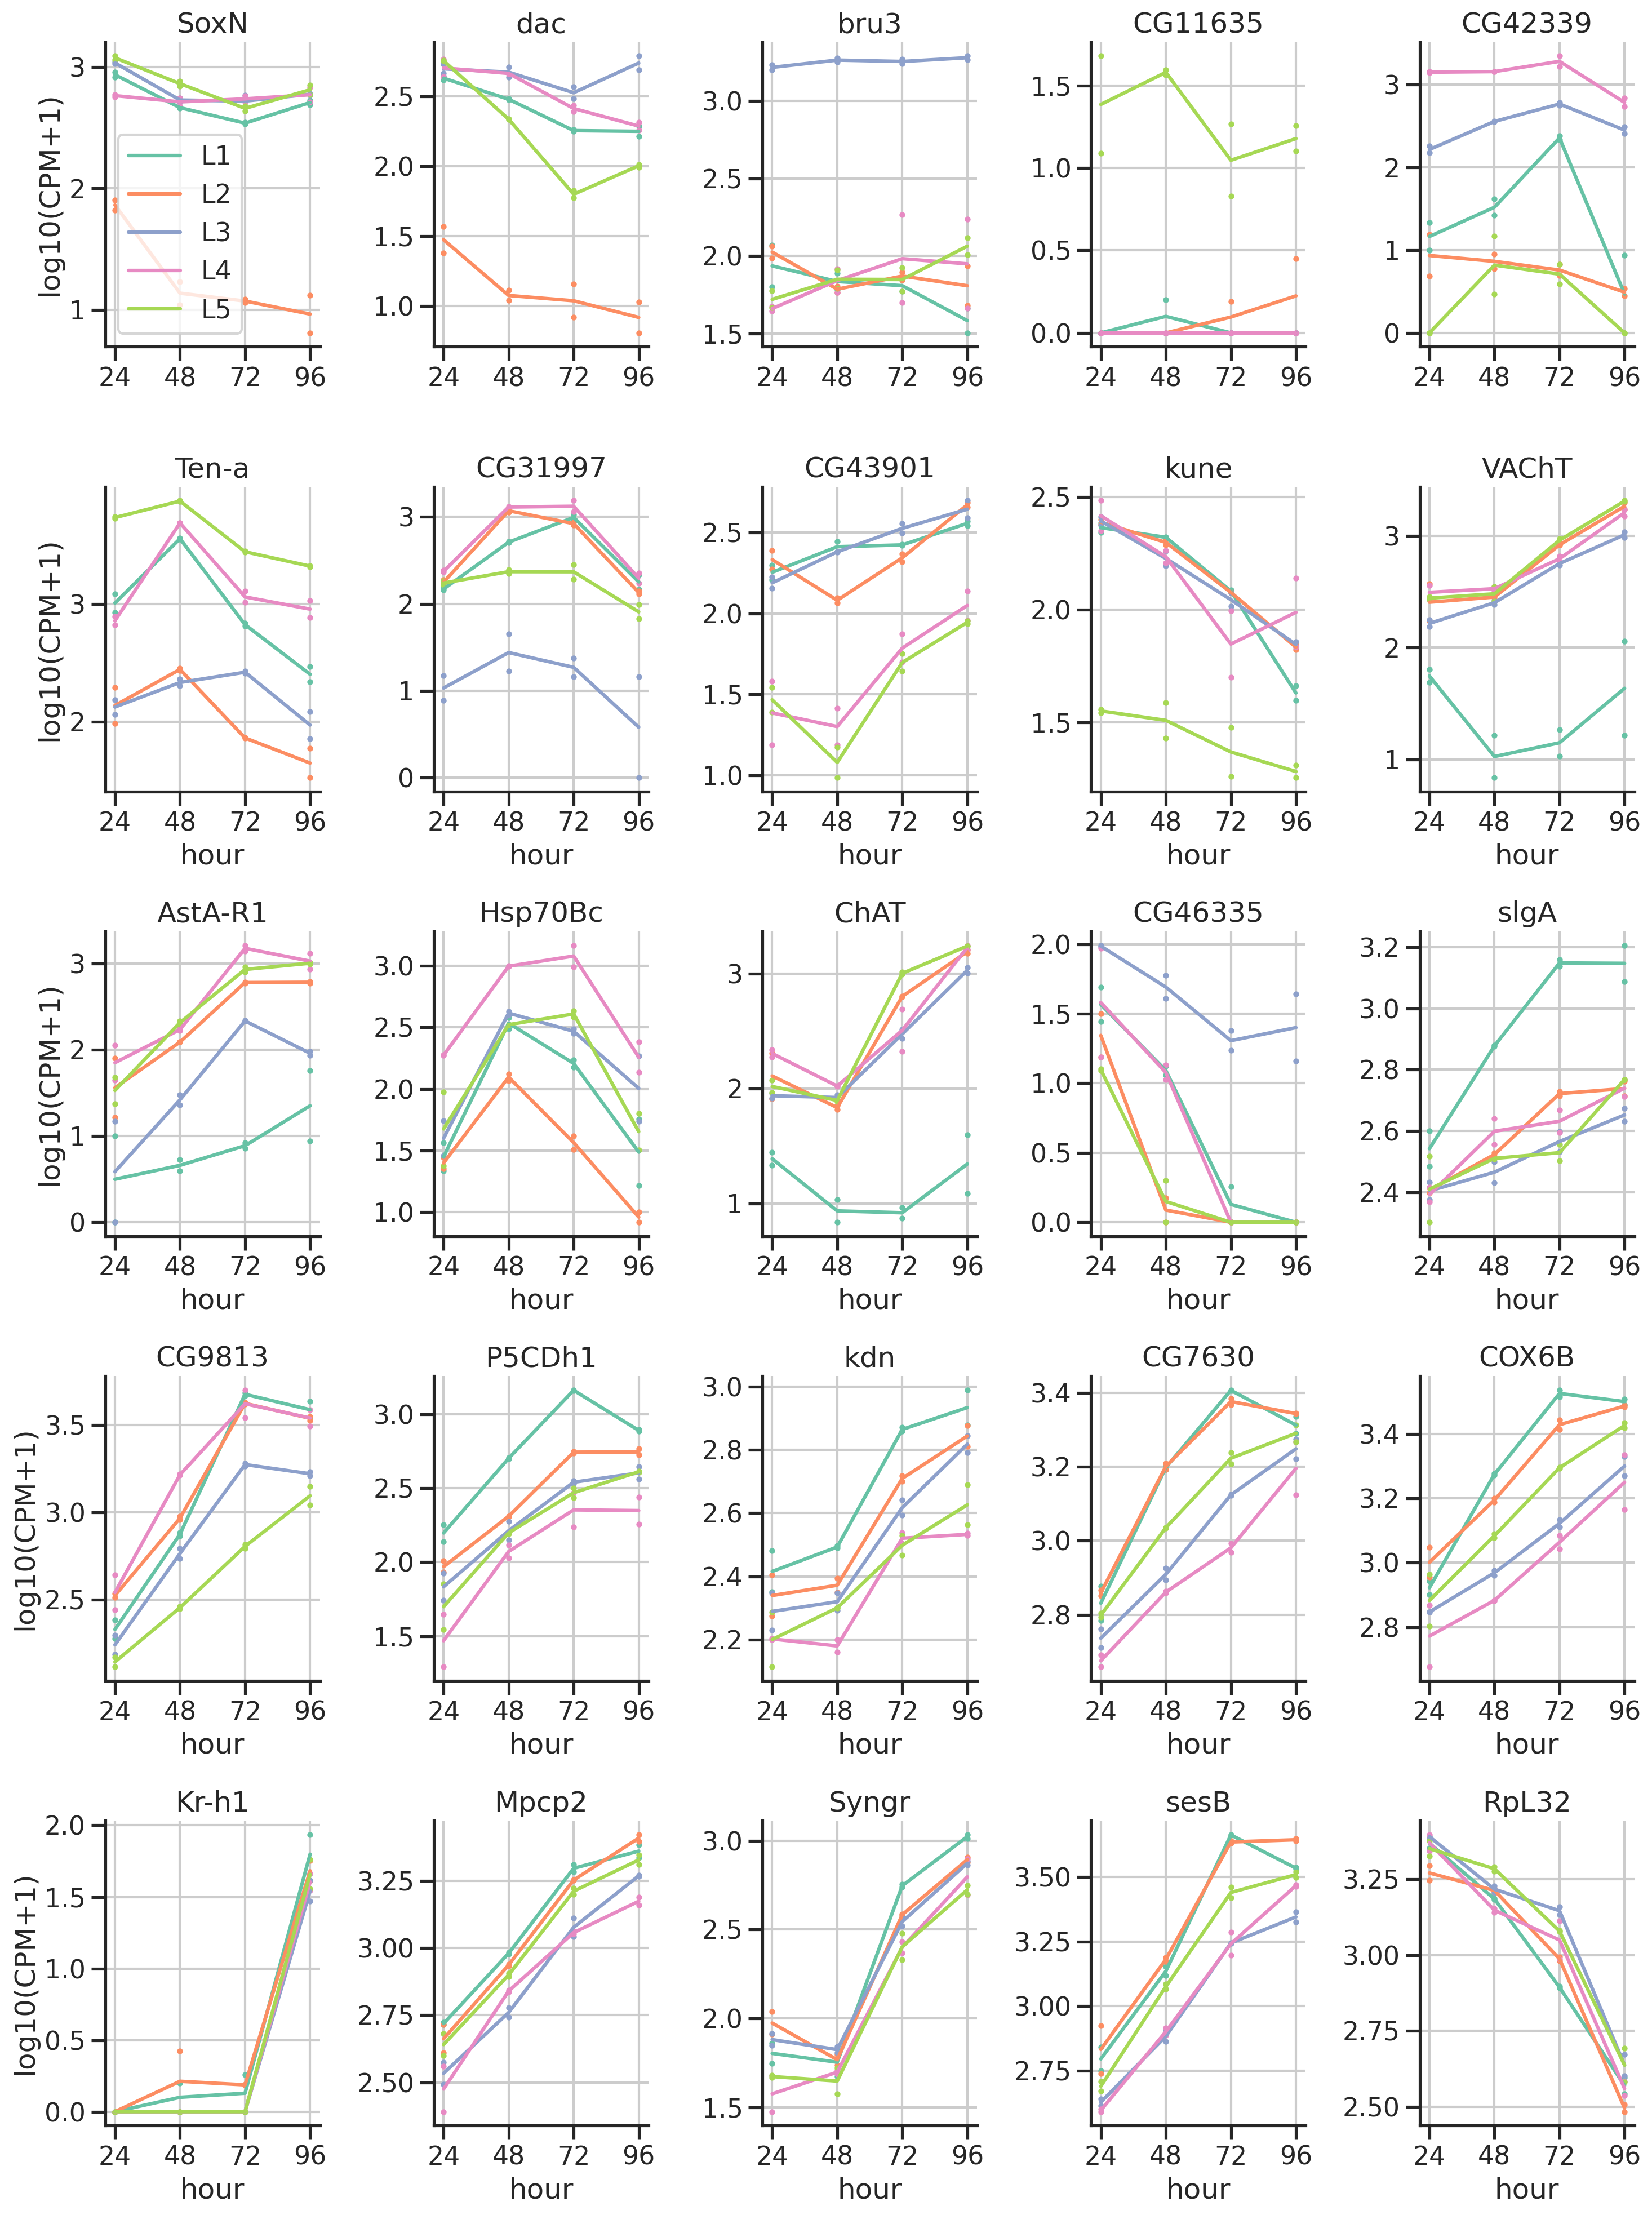

In [25]:
fig, axs = plt.subplots(5,5,figsize=(5*3,5*4)) #, sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(5):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()